# Importing libraries

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, classification_report

# Data augmentation

In [ ]:
dataset_dir = "/dataset"

# Create separate directories for "Normal" and "Abnormal" images
normal_dir = os.path.join(dataset_dir, 'Normal')
abnormal_dir = os.path.join(dataset_dir, 'Abnormal')

os.makedirs(normal_dir, exist_ok=True)
os.makedirs(abnormal_dir, exist_ok=True)

# Iterate over the image files in the dataset directory
for filename in os.listdir(dataset_dir):
    if filename.endswith('.tif'):
        _, label = filename.split('_')
        if label[0] == '0':
            # Move the image file to the "Normal" directory
            shutil.move(os.path.join(dataset_dir, filename), os.path.join(normal_dir, filename))
        elif label[0] == '1':
            # Move the image file to the "Abnormal" directory
            shutil.move(os.path.join(dataset_dir, filename), os.path.join(abnormal_dir, filename))


In [ ]:
# Define a function to apply histogram equalization to an image
def apply_hist_eq(image):
    image_eq = exposure.equalize_hist(image)
    return image_eq*255

In [ ]:
# Define the data augmentation parameters
datagen = []
datagen.append(ImageDataGenerator())
datagen.append(ImageDataGenerator(horizontal_flip=True))
datagen.append(ImageDataGenerator(vertical_flip=True))
datagen.append(ImageDataGenerator(preprocessing_function=apply_hist_eq))  # Apply histogram equalization
datagen.append(ImageDataGenerator(rotation_range=10))  # Rotation in degrees
datagen.append(ImageDataGenerator(height_shift_range=0.3))
datagen.append(ImageDataGenerator(width_shift_range=0.3))
datagen.append(ImageDataGenerator(shear_range=0.2))  # Shearing angle in radians

In [ ]:
temp = datagen[0].flow_from_directory(
    dataset_dir,
    target_size=(257, 257),
    batch_size=260
)
data_array = temp[0][0]
label_array = temp[0][1]
X_train, X_test, Y_train, Y_test = train_test_split(data_array, label_array, test_size=0.2)

Found 260 images belonging to 2 classes.


In [ ]:
X_augmented = X_train
Y_augmented = Y_train

for generator in datagen[1:]:
    temp = generator.flow(X_train, Y_train, batch_size=260)
    data_array = temp[0][0]
    label_array = temp[0][1]

    X_augmented = np.concatenate((X_augmented, data_array), axis=0)
    Y_augmented = np.concatenate((Y_augmented, label_array), axis=0)

In [ ]:
print('number of training samples:', len(X_augmented))
print('number of test samples:', len(X_test))

number of training samples: 1664
number of test samples: 52


# CNN model

In [ ]:
def CNN(input_shape = (257, 257, 3), classes = 2):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = tf.keras.layers.Rescaling(1./255)(X_input)

    # Stage 1
    X = Conv2D(48, (3, 3), strides = (2, 2), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(X)


    # Stage 2
    X = Conv2D(48, (3, 3), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(X)


    # Stage 3
    X = Conv2D(48, (5, 5), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)


    # Stage 4
    X = Conv2D(48, (3, 3), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Stage 5
    X = Conv2D(48, (3, 3), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(X)

    # Stage 6
    X = Flatten()(X)
    X = Dense(1000, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    # output layer
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    print(model.summary())

    return model

In [ ]:
with tf.device('/device:GPU:0'):
    model = CNN()
    history = model.fit(X_augmented, Y_augmented, batch_size=100, epochs=500, validation_data=(X_test, Y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 257, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 257, 257, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 129, 129, 48)      1344      
                                                                 
 activation (Activation)     (None, 129, 129, 48)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 48)        20784     
                                                             

In [ ]:
# Specify the path to save the model
model_path = "/content/drive/MyDrive/IP/HW3/dataset/dataset/model1.h5"

# Save the model
model.save(model_path)

# Evaluation

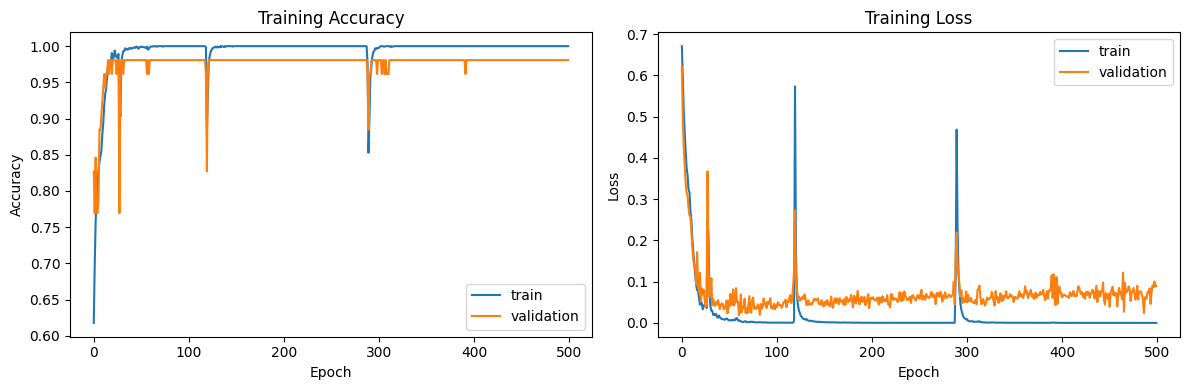

In [ ]:
# Plot the variation of accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='lower right')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(predictions, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Compute precision, recall, and specificity
report = classification_report(y_true_labels, y_pred_labels)

# Print the results
print("Confusion Matrix:")
print(cm)
print("")

print("Classification Report:")
print(report)

2/2 [==============================] - 0s 12ms/step
Confusion Matrix:
[[26  0]
 [ 1 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.96      0.98        26

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52

